In [55]:
import numpy as np

import math
import matplotlib
import matplotlib.pyplot as plt

from scipy import signal
import colorsys
from os import listdir
%matplotlib inline
import scipy.misc

In [56]:
import random
PERCENT_MIN=0.004
PERCENT_MAX=0.02
def createRandomMask(height,width,numberofrect=3):
    mask=np.zeros((height,width))
    rects=[]
    for rect in range(numberofrect) :
        k_0=random.randint(0,height)
        p_0=random.randint(0,width)
        k_1=random.randint(0,height-k_0)+k_0
        p_1=random.randint(0,width-p_0)+p_0
        while (p_1-p_0)*(k_1-k_0)>PERCENT_MAX*height*width or (p_1-p_0)*(k_1-k_0)<PERCENT_MIN*height*width  :
            k_0=random.randint(0,height)
            p_0=random.randint(0,width)
            k_1=random.randint(0,height-k_0)+k_0
            p_1=random.randint(0,width-p_0)+p_0 
        mask[k_0:k_1,p_0:p_1]=1
        rects.append([k_0,k_1,p_0,p_1])
    return mask,rects
def createRandomMaskCV(height,width,numberofrect=3):
    mask=np.zeros((height,width),dtype=np.uint8)
    rects=[]
    for rect in range(numberofrect) :
        k_0=random.randint(0,height)
        p_0=random.randint(0,width)
        k_1=random.randint(0,height-k_0)+k_0
        p_1=random.randint(0,width-p_0)+p_0
        while (p_1-p_0)*(k_1-k_0)>PERCENT_MAX*height*width or (p_1-p_0)*(k_1-k_0)<PERCENT_MIN*height*width  :
            k_0=random.randint(0,height)
            p_0=random.randint(0,width)
            k_1=random.randint(0,height-k_0)+k_0
            p_1=random.randint(0,width-p_0)+p_0 
        mask[k_0:k_1,p_0:p_1]=255
        rects.append([k_0,k_1,p_0,p_1])
    return mask,rects


(380L, 740L, 3L)


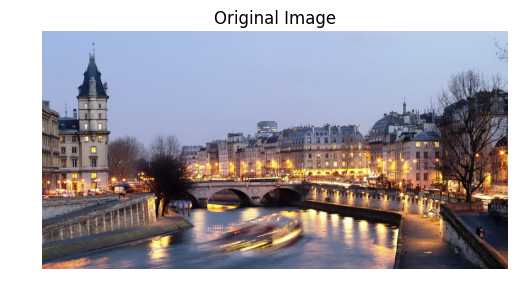

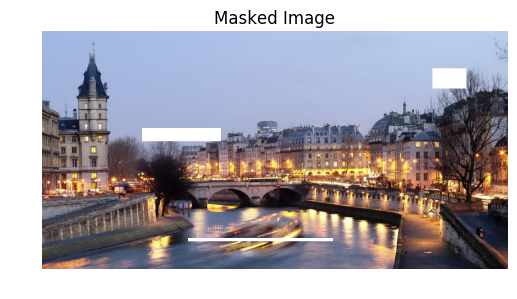

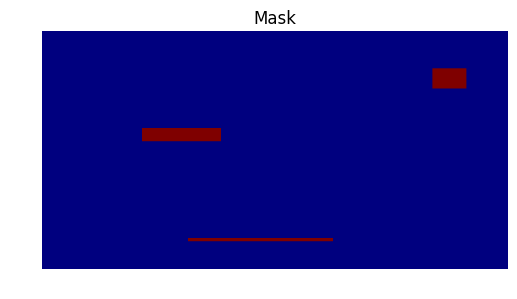

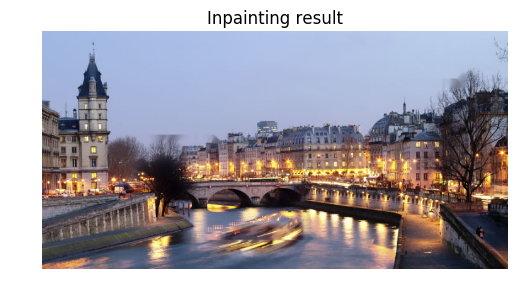

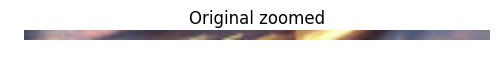

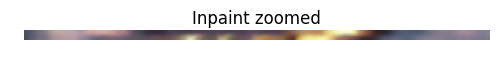

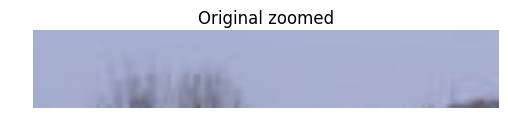

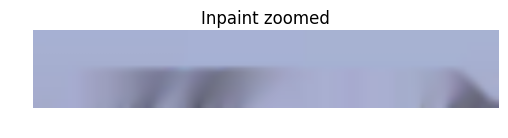

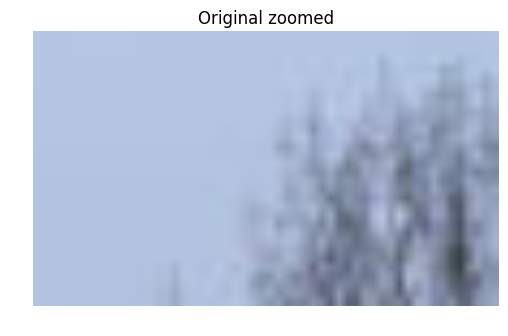

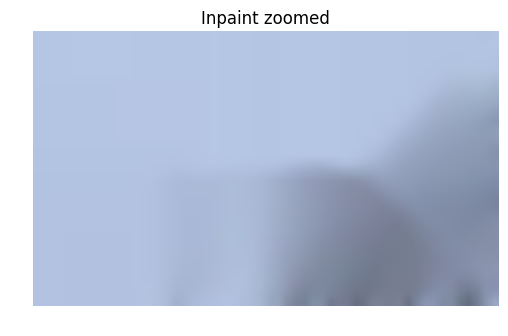

In [57]:
import cv2

path=u'./Images/'
onlypics = [path+f for f in listdir(path) if f[-4:]=='.jpg' and 'Mask' not in f]
for fname in onlypics[1:2] :
    image = Image.open(fname)
    arr = np.asarray(image)
    print(arr.shape)
    plt.imshow(arr)
    plt.axis('off')
    plt.title('Original Image')

    
    plt.show()
    mask,rects=createRandomMaskCV(arr.shape[0],arr.shape[1])
    arrmasked=np.copy(arr)
    for j in range(len(rects)) :
        arrmasked[rects[j][0]:rects[j][1],rects[j][2]:rects[j][3]]=np.array([255,255,255],dtype=np.uint8)
    plt.imshow(arrmasked)
    plt.title('Masked Image')
    plt.axis('off')
    plt.show()
    dst=cv2.inpaint(arr,mask,3,cv2.INPAINT_NS)
    plt.imshow(mask)
    plt.title('Mask')
    plt.axis('off')
    plt.show()
    plt.imshow(dst)
    plt.title('Inpainting result')
    plt.axis('off')
    plt.show()
    
    
    for j in range(len(rects)) :
        
        plt.imshow(arr[rects[j][0]:rects[j][1],rects[j][2]:rects[j][3]])
        plt.title('Original zoomed')
        plt.axis('off')
        plt.show()
        plt.imshow(dst[rects[j][0]:rects[j][1],rects[j][2]:rects[j][3]])
        plt.title('Inpaint zoomed')
        plt.axis('off')
        plt.show()
        

In [27]:
def square_intersect_mask(square,mask):
    """
    Parameters
    ------
    
    square = array-like [X_1,X_2,Y_1,Y_2]
    mask=array-like - Image [height,width] with value 255 for concerned mask 
    
    """
    return 255 in mask[square[0]:square[1],square[2]:square[3]]


In [52]:
from sklearn.base import BaseEstimator
import cv2
class Inpaintingmachines(BaseEstimator):    
    """
    Inpaintingmachines for COBRA usage
    Parameters
    ----------
    inpaint: 
        Which opencv inpaint is chosen
    """

    def __init__(self, inpaint=cv2.INPAINT_TELEA,inpaint_radius=3):
        self.inpaint = inpaint
        self.inpaint_radius=inpaint_radius

    def fit(self, X, mask, square_size=40):
        """
        Idea - build a training set for the machines based on the image X - predict value for each pixel out of the mask using
        a new mask made of the previous one and a square.
        Parameters
        ----------
        X: array-like, image [height, width]
            The masked image that will be used to train some data.
        mask: array-like, image = [height, width]
            Same size as X - mask position (0 or 255).
        square_size : int
            Size of the square that we will add to compute prediction for the known values
        """
        ## Original inpaint
        height,width,_=X.shape
        prediction=np.zeros(X.shape,dtype=np.uint8)
        inpaint=cv2.inpaint(X,mask,self.inpaint_radius,self.inpaint)
        ## This is the test value but we put them in the prediction.
        for j in range(len(mask)):
            for k in range(len(mask[j])):
                prediction[j,k]=inpaint[j,k]
        
        
        square=[0,square_size,0,square_size]
        while square[1]<height :
            while square[3]<width :
                ##do stuff
                
                ## If square intersects mask, prediction == True value for the pixel out of the mask
                if square_intersect_mask(square,mask) :
                    for j in range(square_size):
                        for k in range(square_size):
                            if mask[j,k]==0 :
                                prediction[j,k]=X[j,k]
                ## Else create the new mask and compute the prediction
                else :
                    newmask=np.copy(mask)
                    newmask[square[0]:square[1],square[2]:square[3]]=255
                    newinpaint=cv2.inpaint(X,newmask,self.inpaint_radius,self.inpaint)
                    prediction[square[0]:square[1],square[2]:square[3]]=newinpaint[square[0]:square[1],square[2]:square[3]]
                
                square[2]+=square_size
                square[3]+=square_size
            
            
            square[2]=0
            square[3]=square_size
            square[1]+=square_size
            square[0]+=square_size
        self.prediction=prediction
        self.mask=mask
        self.X=X
        self.inpaint=inpaint

        return self
test=Inpaintingmachines()
test.fit(arr,mask,10)


Inpaintingmachines(inpaint=array([[[160, 185, 226],
        [160, 185, 226],
        ...,
        [184, 208, 236],
        [189, 206, 226]],

       [[160, 185, 226],
        [160, 185, 226],
        ...,
        [184, 208, 236],
        [189, 206, 226]],

       ...,
       [[188, 115,  74],
        [171,  99,  59],
        ...,
        [ 83,  45,  36],
        [ 79,  52,  45]],

       [[204, 122,  98],
        [186, 106,  83],
        ...,
        [ 70,  43,  34],
        [ 66,  49,  42]]], dtype=uint8),
          inpaint_radius=3)

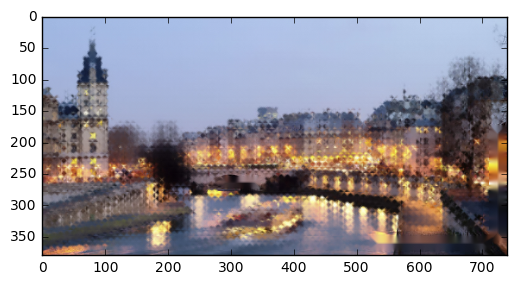

In [53]:
plt.imshow(test.prediction)

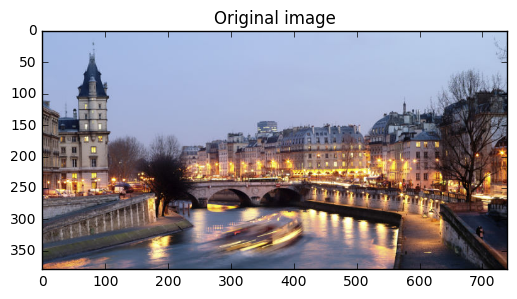

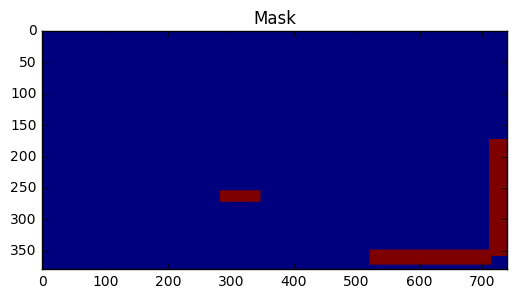

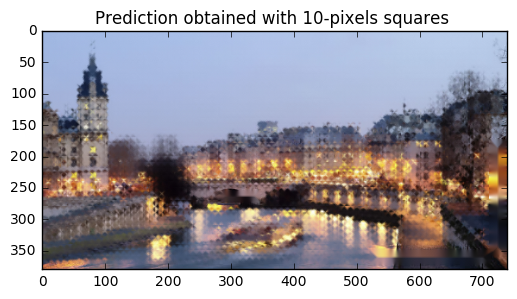

In [54]:
plt.imshow(arr)
plt.title('Original image')
plt.show()
plt.imshow(mask)
plt.title('Mask')
plt.show()
plt.imshow(test.prediction)
plt.title('Prediction obtained with 10-pixels squares ')